In [1]:
import os
import torch
import clip
import numpy as np
import pandas as pd
import pyarrow.feather as feather
from PIL import Image
from urllib import request
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision, torch
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
# proxy="http://sysproxy.wal-mart.com:8080"
# os.environ['http_proxy'] = proxy 
# os.environ['HTTP_PROXY'] = proxy
# os.environ['https_proxy'] = proxy
# os.environ['HTTPS_PROXY'] = proxy


# export HTTP_PROXY=http://sysproxy.wal-mart.com:8080
# export HTTPS_PROXY=http://sysproxy.wal-mart.com:8080

## Enrollment Evaluation

In [ ]:
import os
import torch
import clip
import numpy as np
import pandas as pd
import pyarrow.feather as feather
from PIL import Image
from urllib import request
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision, torch
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
# from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
_, preprocess = clip.load("ViT-B/32", device=device)
# device

# PATH="/home/jupyter/train-CLIP-FT/lightning_logs/version_4/checkpoints/epoch=31-step=16319.ckpt"
PATH = "/home/jupyter/train-CLIP-FT/lightning_logs/version_4/checkpoints/epoch=31-step=4063.ckpt"
model = torch.load(PATH, map_location='cpu')
print("model loaded")
test_label_dict={}
enrollment_label_dict={}


    

    

    
    


metric_agg= pd.DataFrame(columns=["enrollment_batch_size","set_number","accuracy","precision","recall","fbeta_score","weighted_precision","weighted_recall","weighted_fbeta"])

def get_features(dataset, BATCH_SIZE=100):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=BATCH_SIZE)):
            features = model.encode_image(images.to(device))
            # images=images.type(model.dtype)
            # features=loaded(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

acc_df= pd.DataFrame()

for enrollment_size in range(90,91):
    for set_number in [1]:
        # dvc-manual/gtin_60/data/prep/subsets/enrollment_size_{enrollment_size}_SN_{set_number}
        enrollment_path= os.path.join(os.getcwd(),f'dvc-manual/gtin_60/data/prep/80gtin_allsubfolders/80gtin_ET/ET_size_{enrollment_size}')
        enrollment_preprocess= torchvision.datasets.ImageFolder(root=enrollment_path,transform=preprocess)
        # 'dvc-manual/gtin_60/data/prep/test'
        test_path= os.path.join(os.getcwd(),'dvc-manual/gtin_60/data/prep/80gtin_allsubfolders/splitfolders/test')
        test_preprocess= torchvision.datasets.ImageFolder(root=test_path,transform=preprocess)
        
        for k,v in test_preprocess.class_to_idx.items():
            test_label_dict[v]=k
        for k,v in enrollment_preprocess.class_to_idx.items():
            enrollment_label_dict[v]=k
        
        enrollment_features, enrollment_labels = get_features(enrollment_preprocess, 100)
        test_features, test_labels = get_features(test_preprocess, 100)
        
        classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=0)
        classifier.fit(enrollment_features, enrollment_labels)
        
        
        
        predictions = classifier.predict(test_features)
        true_labels=test_labels.copy()
        
        for idx,val in enumerate(test_labels):
            true_labels[idx]=test_label_dict[val]
            
        for idx,val in enumerate(predictions):
            predictions[idx]=enrollment_label_dict[val]
        
        acc= metrics.accuracy_score(np.array(true_labels),np.array(predictions))
        report=sklearn.metrics.classification_report(np.array(true_labels),np.array(predictions))
        prec, rec,fscore,supp=precision_recall_fscore_support(np.array(true_labels),np.array(predictions), average='macro')
        w_prec, w_rec,w_fscore,w_supp=precision_recall_fscore_support(np.array(true_labels),np.array(predictions), average='weighted')
        
        row={"enrollment_batch_size": enrollment_size,
                 "set_number": set_number,
                 "accuracy": acc,
                 "precision":prec,
                 "recall": rec,
                 "fbeta_score": fscore,
                 "weighted_precision": w_prec,
                 "weighted_recall": w_rec,
                 "weighted_fbeta": w_fscore
                }
        metric_agg=metric_agg.append(row,ignore_index=True)
        print(f"Enrollment size = {enrollment_size}")
        print("Accuracy= ", acc)
        
    break

In [1]:
# print(report)

In [2]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


fig = make_subplots(
        rows=1,
        cols=1,
        shared_yaxes=True,
        vertical_spacing=0.01,
        horizontal_spacing=0.01,
        #row_heights=[0.5, 0.5],
        subplot_titles=("Metric: Angular", "Metric: Euclidean")
    )

plt_df1=metric_agg.copy()



fig.add_trace(
        go.Scatter(
            x=plt_df1.enrollment_batch_size, y=plt_df1["accuracy"],mode="markers+text",name="accuracy",legendgroup ='accuracy'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )
fig.add_trace(
        go.Scatter(
            x=plt_df1.enrollment_batch_size, y=plt_df1["precision"],mode="markers+text",name='precision',legendgroup ='precision'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1.enrollment_batch_size, y=plt_df1["fbeta_score"],mode="markers+text",name='fbeta_score',legendgroup ='fbeta_score'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1.enrollment_batch_size, y=plt_df1["recall"],mode="markers+text",name='recall',legendgroup ='recall'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )


# fig.layout.annotations[1].update(text="Metric=Angular")
fig.update_xaxes(title_text="Enrollment Size", row=1, col=1, title_font_size=10)
# fig.update_yaxes(title_text="Metrics in %", row=1, col=2, title_font_size=10)
# fig.update_yaxes(title_text="Metrics in %", row=1, col=2, title_font_size=10)

fig.update_layout(
        height=800,
        width=1400,
        # xaxis_rangeslider_visible=False,
        xaxis_rangebreaks=[dict(values=[x for x in range(30,150,10)])]
    )

fig.show()

In [34]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(np.float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 97.403


In [99]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.92      0.96      0.94       111
           2       0.99      0.99      0.99       142
           3       0.94      1.00      0.97        46
           4       0.96      0.96      0.96       120
           5       1.00      1.00      1.00       125
           6       0.99      0.98      0.98        99
           7       0.97      0.94      0.96       119
           8       0.95      0.99      0.97       103
           9       0.99      0.99      0.99       114
          10       0.99      0.99      0.99        92
          11       0.99      0.97      0.98       115
          12       0.98      0.97      0.98       114
          13       0.97      0.95      0.96       109
          14       0.98      1.00      0.99        51

    accuracy                           0.98      1504
   macro avg       0.98      0.98      0.98      1504
weighted avg       0.98   

## Indexer based testing

In [5]:
def predict(model,classifier, test_loader,opt,pred_save_path,pred_filename,metrics_file_name):
    """
        Make predictions and save them in a pickle file.
        Print Classification metrics
        
        Arguments:
            model: Trained encoder model 
            classifier: Trained MLP
            valdata: Data to make predictions on
            test_loader: Data Loader created on valdata
            fname: Name of file to in which predictions will be saved
            
        Returns:
            List with predictions on valdata
    """     
    model.eval()
    classifier.eval()
    with torch.no_grad():
        pred1=[]
        print("Start Predictions")
        # Iterate over data.
        for idx, (images, labels) in enumerate(test_loader):
                images = images.float().cuda()
                output = classifier(model.encoder(images))
                _,preds=torch.max(output, 1)
                pred1.extend(preds.cpu().numpy())
                
    p=np.array(pred1)

    import pickle
    print('Prediction file saved here: ', os.path.join(pred_save_path,pred_filename))
    with open(os.path.join(pred_save_path,pred_filename), 'wb') as handle:
        pickle.dump(p, handle, protocol=pickle.HIGHEST_PROTOCOL)
    top_1_df = pd.DataFrame(columns=['true_label', 'predicted_label'])
    top_1_df['true_label']=np.array(test_loader.dataset.targets)
    top_1_df['predicted_label']= pred1
    top_1_df['true_label_gtin']=top_1_df['true_label'].apply(lambda x:val_rev_item_dict[x])
    top_1_df['predicted_label_gtin']=top_1_df['predicted_label'].apply(lambda x:train_rev_item_dict[x])
    # print(sklearn.metrics.classification_report(np.array(top_1_df['true_label_gtin']),np.array(top_1_df['predicted_label_gtin'])))
    print(top_1_df.head(10))
    print("")
    # metrics={"accuracy": sklearn.metrics.accuracy_score(np.array(test_loader.dataset.targets), pred1),
    #             "classification_report": sklearn.metrics.classification_report(np.array(test_loader.dataset.targets),pred1)
    #         }
    metrics={"accuracy": sklearn.metrics.accuracy_score(np.array(top_1_df['true_label_gtin']),np.array(top_1_df['predicted_label_gtin'])),
                "classification_report": sklearn.metrics.classification_report(np.array(top_1_df['true_label_gtin']),np.array(top_1_df['predicted_label_gtin']))
            }
    

    print('Metrics file saved here: ', os.path.join(pred_save_path,metrics_file_name))
    with open(os.path.join(pred_save_path,metrics_file_name), 'w') as handle:
        json.dump(metrics,handle)
    print("Accuracy is",sklearn.metrics.accuracy_score(np.array(top_1_df['true_label_gtin']),np.array(top_1_df['predicted_label_gtin'])))
    print(sklearn.metrics.classification_report(np.array(top_1_df['true_label_gtin']),np.array(top_1_df['predicted_label_gtin'])))
    return pred1

In [118]:
import os
import itertools
import numpy as np
import pickle
import sklearn
from sklearn import metrics
from annoy import AnnoyIndex
import pandas as pd
import faiss
import argparse
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def top1(metric_folder,train_X_df,test_X_df,annoy_metrics, train_rev_item_dict,val_rev_item_dict,n_trees=10,k_nearest_neighbor=1):
    """
                Calculate classification metrics using image similarity
                Arguments:
                    train_X_df: pd.Dataframe with train embeddings and labels
                    test_X_df: pd.Dataframe with test embeddings and labels
                    annoy_metrics: List of annoy similarity scores to be calculated
                    n_trees: Parameter for annoy similarity
                Returns:
                   Dictionary with all metrics
                   Saves dictionary as json
    """
    indexer_pth=os.path.join(metric_folder,'indexers')
    print(indexer_pth)
    if not os.path.exists(indexer_pth):
        os.mkdir(indexer_pth)


    metric_dict={}
    metric_dict['test_image_cnt']=test_X_df.shape[0]
    print('Total Test images= ', test_X_df.shape[0])
    print("")


    if not annoy_metrics:
        return
    for m in annoy_metrics:
        print('Metric =%s' % m)
        f = len(train_X_df['embedding'][0])
        t = AnnoyIndex(f, m)  # Length of item vector that will be indexed

        for i, vec in enumerate(train_X_df['embedding']):
            t.add_item(i, vec)

        t.build(n_trees, n_jobs=-1)  # 10 trees
        t.save(os.path.join(indexer_pth,str(m) + '.ann'))

        u = AnnoyIndex(f, m)  # Length of item vector that will be indexed
        u.load(os.path.join(indexer_pth,str(m) + '.ann'))  # super fast, will just mmap the file
        top_1 = pd.DataFrame(columns=['true_label', 'predicted_label'])
        for i in range(int(test_X_df.shape[0])):
            # print(u.get_nns_by_vector(test_X_df.loc[i, 'embedding'], k_nearest_neighbor))
            # print(int(train_X_df.iloc[int(u.get_nns_by_vector(test_X_df.loc[i, 'embedding'], 1)[0]), 1]))
            # pred_label = int(train_X_df.iloc[int(u.get_nns_by_vector(test_X_df.loc[i, 'embedding'], 1)[0]), 1])
            query= test_X_df.loc[i, 'embedding']
            pred_labels_idx= u.get_nns_by_vector(query, k_nearest_neighbor)
            pred_labels= [train_X_df.loc[x, "label"] for x in pred_labels_idx]
            pred_label= pd.Series(pred_labels).value_counts().index[0]
            # pred_label = np.bincount(pred_labels).argmax()
            # neighbors_df=pd.DataFrame({"neighbor_indices": pred_labels_idx,"neighbor_labels":pred_labels })
            # neighbors_df['freq'] = neighbors_df.groupby('neighbor_labels')['neighbor_labels'].transform('count')
            # neighbors_df.sort_values(by='freq',ascending=False,inplace=True)
            # print(neighbors_df)
            
            
            
            true_label = int(test_X_df.iloc[i, 1])
            # print(f"Indexes: {pred_labels_idx}. Pred labels are: {pred_labels} majority voted label is {pred_label}.True label: {true_label} ")
            
            top_1 = top_1.append(pd.Series([true_label, pred_label], index=top_1.columns), ignore_index=True)

        top_1['true_label'] = top_1['true_label'].astype(int)
        top_1['predicted_label'] = top_1['predicted_label'].astype(int)

        top_1['true_label_gtin']=top_1['true_label'].apply(lambda x:val_rev_item_dict[x])
        top_1['predicted_label_gtin']=top_1['predicted_label'].apply(lambda x:train_rev_item_dict[x])

        acc= metrics.accuracy_score(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']))
        correct=metrics.accuracy_score(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']),normalize=False)
        prec, rec,fscore,supp=precision_recall_fscore_support(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']), average='macro')
        w_prec, w_rec,w_fscore,w_supp=precision_recall_fscore_support(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']), average='weighted')
        report=sklearn.metrics.classification_report(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']))
        report_dict=sklearn.metrics.classification_report(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']),output_dict=True)


        # acc= metrics.accuracy_score(np.array(top_1['true_label']), np.array(top_1['predicted_label']))
        # correct=metrics.accuracy_score(np.array(top_1['true_label']), np.array(top_1['predicted_label']),normalize=False)
        # report=sklearn.metrics.classification_report(np.array(top_1['true_label']),np.array(top_1['predicted_label']))

        metric_dict[f'annoy_{m}_{str(k_nearest_neighbor)}nn']={'accuracy':acc,'precision': prec,"recall": rec,"fbeta": fscore,"support": supp,\
                                 'weighted_precision': w_prec,"weighted_recall": w_rec,"weighted_fbeta": w_fscore,"weighted_support": w_supp,\
                                 'classification_report':report,'classification_report_dict':report}

    ##### FAISS EMBEDS ####
    # print("Metric =faiss_l2")
    # embeds = []
    # for a in train_X_df['embedding']:
    #     embeds.append(a)
    # test_embeds = []
    # for a in test_X_df['embedding']:
    #     test_embeds.append(a)
    # index = faiss.IndexFlatL2(2048)  # build the index
    # index.add(np.array(embeds))

    # top_1 = pd.DataFrame(columns=['true_label', 'predicted_label'])
    # for i in range(test_X_df.shape[0]):
    #     pred_label = int(train_X_df.iloc[index.search(np.array([test_embeds[i]]), 1)[1][0][0]].label)
    #     true_label = int(test_X_df.iloc[i, 1])
    #     top_1 = top_1.append(pd.Series([true_label, pred_label], index=top_1.columns), ignore_index=True)

    # top_1['true_label'] = top_1['true_label'].astype(int)
    # top_1['predicted_label'] = top_1['predicted_label'].astype(int)
    
    # top_1['true_label_gtin']=top_1['true_label'].apply(lambda x:val_rev_item_dict[x])
    # top_1['predicted_label_gtin']=top_1['predicted_label'].apply(lambda x:train_rev_item_dict[x])
    # print(sklearn.metrics.classification_report(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin'])))
    
    # acc= metrics.accuracy_score(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']))
    # correct=metrics.accuracy_score(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']),normalize=False)
    # report=sklearn.metrics.classification_report(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']))
    
    # print("Accuracy is", acc)
    # print("Correct Label Count: ",correct)
    
    # metric_dict['faiss_l2'] = {'accuracy': acc, 'classification_report': report}
    # print("")

    return metric_dict

def saveMetric(metric_dict, dir,dataset_name="train_enrollment",n_trees=10,eset=None):
    """
                    Save metrics in json format
                    Arguments:
                        metric_dict: dict object to be saved
    """
    if eset:
        with open(os.path.join(dir,f'{dataset_name}_{eset}_nt{n_trees}_metrics.json'), 'w') as handle:
            json.dump(metric_dict,handle)
    else:
        with open(os.path.join(dir,f'{dataset_name}_nt{n_trees}_metrics.json'), 'w') as handle:
            json.dump(metric_dict,handle)
        
    print('JSON saved')


### Find optimal K

In [181]:
# gtin_enrollment_label= enrollment_labels.copy()
# gtin_test_label= test_labels.copy()

# for idx,val in enumerate(enrollment_labels):
#     gtin_enrollment_label[idx]=enrollment_label_dict[val]

# for idx,val in enumerate(test_labels):
#     gtin_test_label[idx]=test_label_dict[val]

edf = pd.DataFrame(columns=['embedding', 'label'])
for i,j in zip(enrollment_features, enrollment_labels):
    edf=edf.append({'embedding': i, "label": j},ignore_index=True)
    
    
test_X_df = pd.DataFrame(columns=['embedding', 'label'])
for i,j in zip(test_features, test_labels):
    test_X_df=test_X_df.append({'embedding': i, "label": j},ignore_index=True)
    


In [184]:
annoy_metrics=['angular','euclidean']
n_trees=10
metric_folder= "/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics"
dataset_name= 'train_enrollment'

k_effect=pd.DataFrame(columns=["n_trees","test_image_cnt", "k","Annoy_angular_acc","Annoy_euclidean_acc", "Annoy_angular_prec", "Annoy_euclidean_prec","Annoy_angular_rec","Annoy_euclidean_rec",\
                              "Annoy_angular_fbeta", "Annoy_euclidean_fbeta"])
for nt in range(5,50,5):
    for k in range(3,4):
        print(f"n_trees = {nt}")
        print(f"Testing k = {k}")
        row={}
        metric_dict=top1(metric_folder,edf, test_X_df, annoy_metrics,enrollment_label_dict,test_label_dict, n_trees=nt, k_nearest_neighbor=k)
        row["n_trees"]= nt
        row["test_image_cnt"]= metric_dict["test_image_cnt"]
        row["k"]= k
        row["Annoy_angular_acc"]= metric_dict[f"annoy_angular_{k}nn"]["accuracy"]
        row["Annoy_euclidean_acc"]= metric_dict[f"annoy_euclidean_{k}nn"]["accuracy"]
        row["Annoy_angular_prec"]= metric_dict[f"annoy_angular_{k}nn"]["weighted_precision"]
        row["Annoy_euclidean_prec"]= metric_dict[f"annoy_euclidean_{k}nn"]["weighted_precision"]
        row["Annoy_angular_rec"]= metric_dict[f"annoy_angular_{k}nn"]["weighted_recall"]
        row["Annoy_euclidean_rec"]= metric_dict[f"annoy_euclidean_{k}nn"]["weighted_recall"]
        row["Annoy_angular_fbeta"]= metric_dict[f"annoy_angular_{k}nn"]["weighted_fbeta"]
        row["Annoy_euclidean_fbeta"]= metric_dict[f"annoy_euclidean_{k}nn"]["weighted_fbeta"]
        k_effect= k_effect.append(row, ignore_index=True)

k_effect.to_csv("k_effect_80gtin.csv")
        # row["distance_metric"]= metric_dict.keys()[1].split("_")[1]
        # saveMetric(metric_dict,metric_folder,dataset_name,nt)

n_trees = 5
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test images=  10661

Metric =angular
Metric =euclidean
n_trees = 10
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test images=  10661

Metric =angular
Metric =euclidean
n_trees = 15
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test images=  10661

Metric =angular
Metric =euclidean
n_trees = 20
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test images=  10661

Metric =angular
Metric =euclidean
n_trees = 25
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test images=  10661

Metric =angular
Metric =euclidean
n_trees = 30
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test images=  10661

Metric =angular
Metric =euclidean
n_trees = 35
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test i

In [185]:
# k_effect_3= k_effect[k_effect["k"]==3]
# k_effect[k_effect["k"]==1]
k_effect.sort_values(by = ["Annoy_angular_acc"],ascending=False)

,n_trees,test_image_cnt,k,Annoy_angular_acc,Annoy_euclidean_acc,Annoy_angular_prec,Annoy_euclidean_prec,Annoy_angular_rec,Annoy_euclidean_rec,Annoy_angular_fbeta,Annoy_euclidean_fbeta
7,40.0,10661.0,3.0,0.827690,0.836225,0.840537,0.846983,0.827690,0.836225,0.829958,0.837686
6,35.0,10661.0,3.0,0.827221,0.834725,0.840311,0.845577,0.827221,0.834725,0.829539,0.836180
8,45.0,10661.0,3.0,0.827127,0.836694,0.840151,0.847225,0.827127,0.836694,0.829523,0.838057
5,30.0,10661.0,3.0,0.826939,0.834725,0.839306,0.845126,0.826939,0.834725,0.828934,0.836116
4,25.0,10661.0,3.0,0.825251,0.830504,0.837015,0.841232,0.825251,0.830504,0.827070,0.832001
3,20.0,10661.0,3.0,0.823469,0.829941,0.835269,0.840337,0.823469,0.829941,0.825290,0.831331
2,15.0,10661.0,3.0,0.822156,0.826939,0.834076,0.837580,0.822156,0.826939,0.824154,0.828370
1,10.0,10661.0,3.0,0.818966,0.823844,0.830979,0.834104,0.818966,0.823844,0.820902,0.825108
0,5.0,10661.0,3.0,0.808648,0.816059,0.820861,0.827492,0.808648,0.816059,0.810549,0.817416


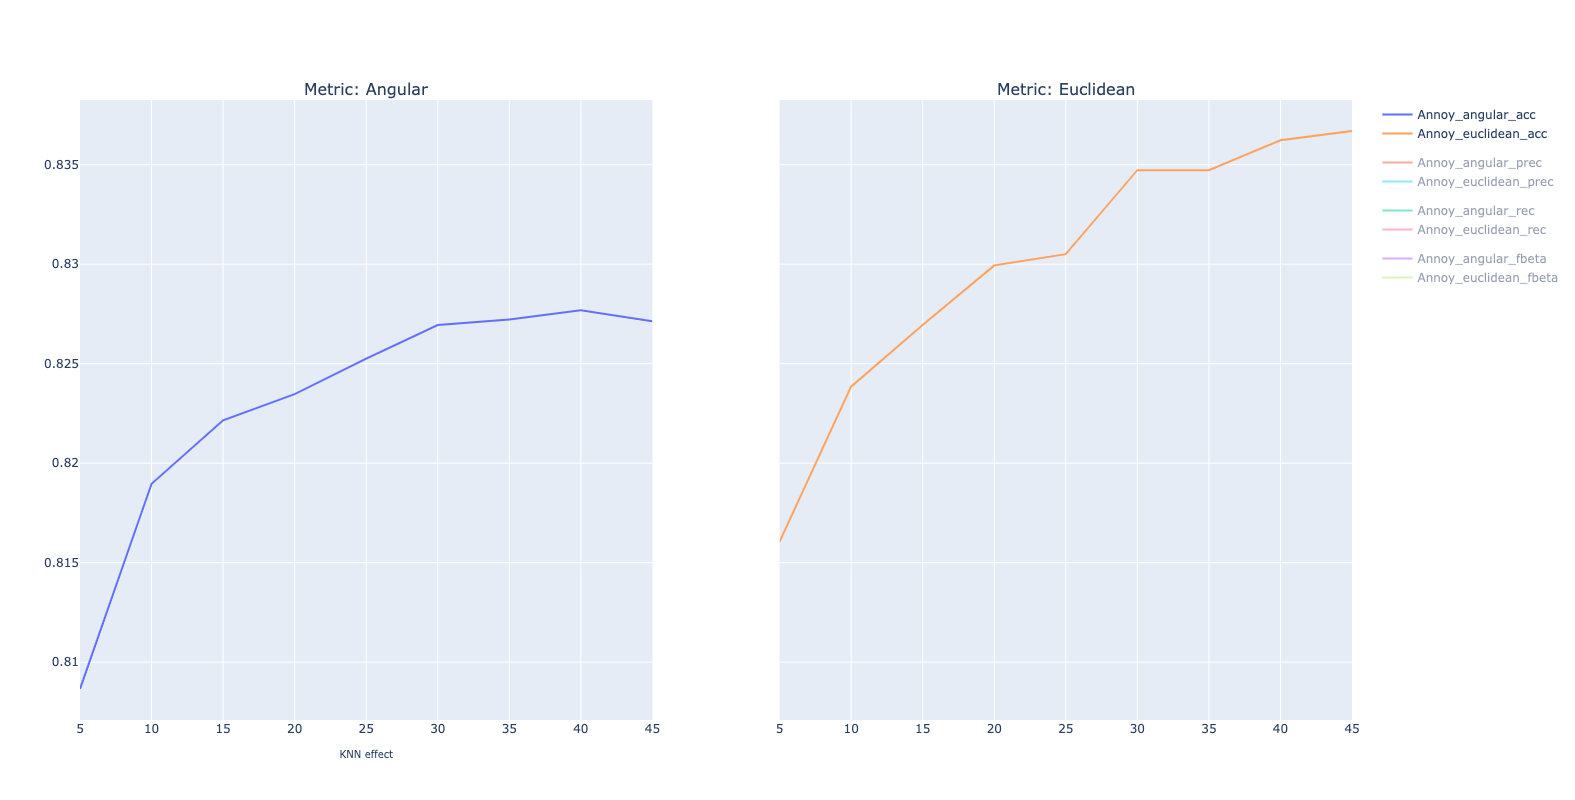

In [189]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


fig = make_subplots(
        rows=1,
        cols=2,
        shared_yaxes=True,
        vertical_spacing=0.01,
        horizontal_spacing=0.1,
        # row_heights=[0.5, 0.5],
        subplot_titles=("Metric: Angular", "Metric: Euclidean")
    )

plt_df1=k_effect.copy()


mode="lines"# "markers+text"
x_col= "n_trees"
fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_angular_acc"],mode=mode,name="Annoy_angular_acc",legendgroup ='accuracy'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )
fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_angular_prec"],mode=mode,name='Annoy_angular_prec',legendgroup ='precision'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_angular_rec"],mode=mode,name='Annoy_angular_rec',legendgroup ='recall'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_angular_fbeta"],mode=mode,name='Annoy_angular_fbeta',legendgroup ='fbeta_score'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_euclidean_acc"],mode=mode,name="Annoy_euclidean_acc",legendgroup ='accuracy'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=2,
    )
fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_euclidean_prec"],mode=mode,name='Annoy_euclidean_prec',legendgroup ='precision'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=2,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_euclidean_rec"],mode=mode,name='Annoy_euclidean_rec',legendgroup ='recall'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=2,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_euclidean_fbeta"],mode=mode,name='Annoy_euclidean_fbeta',legendgroup ='fbeta_score'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=2,
    )

# fig.layout.annotations[1].update(text="Metric=Angular")
fig.update_xaxes(title_text="KNN effect", row=1, col=1, title_font_size=10)
# fig.update_yaxes(title_text="Metrics in %", row=1, col=2, title_font_size=10)
# fig.update_yaxes(title_text="Metrics in %", row=1, col=2, title_font_size=10)

fig.update_layout(
        height=800,
        width=1400,
        # xaxis_rangeslider_visible=False,
        xaxis_rangebreaks=[dict(values=[x for x in range(30,150,10)])]
    )

fig.show()

## Triton Deployment

In [54]:
import os
import sys
from datetime import datetime
import torch

class Saver:
    def __init__(self):
        self.date = str(datetime.now().date())

    def save_model(self,model, opt, save_file):
        print('==> Saving...')
        state = {
            'opt': opt,
            'model': model.state_dict(),
            # 'optimizer': optimizer.state_dict(),
            # 'epoch': epoch,
        }
        torch.save(state, save_file)
        del state


    def model_saver(self, model,  opt, save_file):
        save_file_path=os.path.join(save_file)#'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))    
        self.save_model(model, opt, save_file_path)
        return save_file_path    

opt={"model": "CLIP",
     "save_folder": "/home/jupyter/dvc-manual/gtin_60/models/CLIP",
    }

save_file = os.path.join(opt["save_folder"], f'clip_encoder_{enrollment_size}_{set_number}.pth')
svr= Saver()
svr.model_saver(model, opt, save_file)

==> Saving...


'/home/jupyter/dvc-manual/gtin_60/models/CLIP/clip_encoder_90_1.pth'

In [85]:
enrollment_features.dtype

dtype('float16')

In [84]:
## Save TorchScript model

def saveTorchScriptModel(opt,model):
    model_name="CLIP"
    folder_save= "/home/jupyter/dvc-manual/gtin_60/models/CLIP"
    if not os.path.isdir(folder_save):
        os.makedirs(folder_save, mode=0o777)
    
    folder_save_model= os.path.join(folder_save,"1")
    if not os.path.isdir(folder_save_model):
        os.makedirs(folder_save_model, mode=0o777)

    img_size=(224,224)
    img=torch.randn(1, 3, img_size[0],img_size[1]).type(model.dtype).cuda()

    traced_model = torch.jit.trace(model.visual,img)
    traced_model.save(os.path.join(folder_save_model,'model.pt'))

   
    x = 'name: "{}"'.format(model_name)
    config=x +' \nplatform: "pytorch_libtorch" \ninput [ \n{\nname: "input__0"\ndata_type: TYPE_FP16\ndims: [-1, 3,224,224]\n} \n]\noutput {\nname: "output__0"\ndata_type: TYPE_FP16\ndims: [-1, 512]\n}'

    pbtxt_file = open(os.path.join(folder_save,'config.pbtxt'), "w")
    pbtxt_file.write(config)
    pbtxt_file.close()





saveTorchScriptModel(opt,model)
    

In [86]:
loaded = torch.jit.load('/home/jupyter/dvc-manual/gtin_60/models/CLIP/1/model.pt')